Dataset downloaded to: /kaggle/input/phishing-email-dataset
Loaded 159,163 total rows from 6 CSVs.
Using 'body' as text column and 'label' as label column.
                                                text  label
0  Buck up, your troubles caused by small dimensi...      1
1  \nUpgrade your sex and pleasures with these te...      1
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1
3  Would anyone object to removing .so from this ...      0
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1

Class balance:


,count,percentage
label,,
1,41173,53.696676
0,35504,46.303324


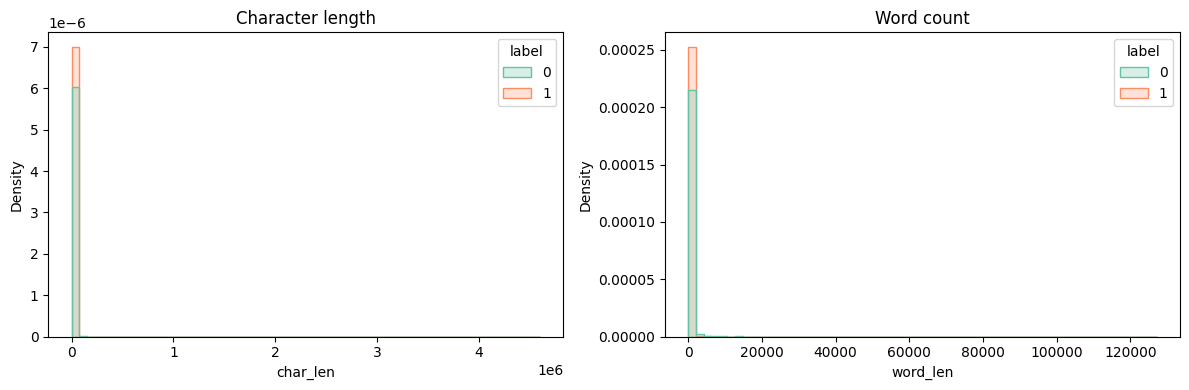

Train size: 61,341  |  Test size: 15,336
Sparse matrix size: (61341, 1017504)

Accuracy :  0.980
Precision: 0.996   Recall: 0.967   F1-score: 0.981

              precision    recall  f1-score   support

 Ham / Legit       0.96      1.00      0.98      7101
Phish / Spam       1.00      0.97      0.98      8235

    accuracy                           0.98     15336
   macro avg       0.98      0.98      0.98     15336
weighted avg       0.98      0.98      0.98     15336



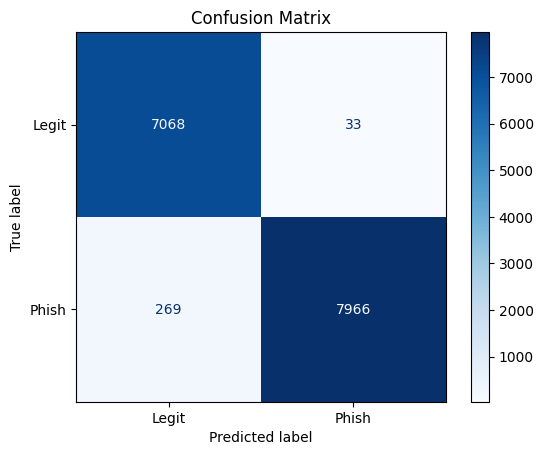

Sample e-mail spam probability: 100.00%


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['percentage'].plot(kind='hist', bins=20, title='percentage')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='count', y='percentage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['percentage'].plot(kind='line', figsize=(8, 4), title='percentage')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['percentage'].plot(kind='hist', bins=20, title='percentage')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='label', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='count', y='percentage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['percentage'].plot(kind='line', figsize=(8, 4), title='percentage')
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
# ─────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re, string, os, textwrap

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

plt.style.use("default")
sns.set_palette("Set2")

# ─────────────────────────────────────────────
# 1. Dataset download & load
# ─────────────────────────────────────────────
import kagglehub
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
print(f"Dataset downloaded to: {path}")

csv_files = [
    "CEAS_08.csv",
    "Nazario.csv",
    "Nigerian_Fraud.csv",
    # "SpamAssassin.csv", # Removed this file as it's missing
    "Enron.csv",
    "Ling.csv",
    "phishing_email.csv",
]

dfs = []
for f in csv_files:
    fp = Path(path, f)
    if not fp.exists():
        raise FileNotFoundError(f"Expected {fp} but it is missing!")
    df = pd.read_csv(fp)
    df["source_file"] = f
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)
print(f"Loaded {raw.shape[0]:,} total rows from {len(csv_files)} CSVs.")

# ─────────────────────────────────────────────
# 2. Normalise column names → 'text' & 'label'
# ─────────────────────────────────────────────
# The various CSVs have slightly different schemas.
# Common text fields: 'text', 'body', 'Email', 'Message'
# Common label fields: 'label', 'class', 'Category', 'phishing'
TEXT_COL_CANDIDATES  = ["text", "body", "Email", "Message"]
LABEL_COL_CANDIDATES = ["label", "class", "Category", "phishing"]

def find_first_existing(cols, candidates, kind):
    for c in candidates:
        if c in cols:
            return c
    raise ValueError(f"No {kind} column found! Candidates tried: {candidates}")

text_col  = find_first_existing(raw.columns, TEXT_COL_CANDIDATES,  "text")
label_col = find_first_existing(raw.columns, LABEL_COL_CANDIDATES, "label")

print(f"Using '{text_col}' as text column and '{label_col}' as label column.")

# Keep only the columns we need
df = raw[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})

# If label isn’t already 0/1, map it
if df["label"].dtype == object:
    # make phishing/spam → 1 and ham/legit → 0 (case-insensitive match on typical keywords)
    df["label"] = (
        df["label"]
        .str.lower()
        .apply(lambda x: 1 if re.search(r"(spam|phish|fraud|scam|attack)", x) else 0)
    )

# Drop rows with missing text values
df.dropna(subset=["text"], inplace=True)

print(df.head())

# ─────────────────────────────────────────────
# 3. Basic EDA
# ─────────────────────────────────────────────
print("\nClass balance:")
display(df["label"].value_counts(dropna=False).to_frame("count").assign(percentage=lambda d: d["count"]/len(df)*100))

df["char_len"]  = df["text"].str.len()
df["word_len"]  = df["text"].str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data=df, x="char_len", hue="label", bins=60, element="step", ax=ax[0], stat="density")
ax[0].set_title("Character length")
sns.histplot(data=df, x="word_len", hue="label", bins=60, element="step", ax=ax[1], stat="density")
ax[1].set_title("Word count")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# 4. Train / test split
# ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

print(f"Train size: {len(X_train):,}  |  Test size: {len(X_test):,}")

# ─────────────────────────────────────────────
# 5. Bag-of-Words vectoriser
# ─────────────────────────────────────────────
vectoriser = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),      # unigrams + bigrams
    min_df=2,               # ignore very rare tokens
)

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec  = vectoriser.transform(X_test)

print(f"Sparse matrix size: {X_train_vec.shape}")

# ─────────────────────────────────────────────
# 6. Multinomial Naïve Bayes classifier
# ─────────────────────────────────────────────
clf = MultinomialNB(alpha=1.0)   # Laplace smoothing
clf.fit(X_train_vec, y_train)

# ─────────────────────────────────────────────
# 7. Evaluation
# ─────────────────────────────────────────────
y_pred = clf.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print(f"\nAccuracy : {acc: .3f}")
print(f"Precision: {prec:.3f}   Recall: {rec:.3f}   F1-score: {f1:.3f}\n")
print(classification_report(y_test, y_pred, target_names=["Ham / Legit", "Phish / Spam"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Legit", "Phish"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ─────────────────────────────────────────────
# 8. Quick demo prediction
# ─────────────────────────────────────────────
sample_mail = """
Dear user,

Your account will be suspended in 24 hours unless you verify your password.
Click here http://malicious.link to confirm your details.

Thank you,
IT Support
"""

prob_spam = clf.predict_proba(vectoriser.transform([sample_mail]))[0,1]
print(f"Sample e-mail spam probability: {prob_spam:.2%}")

**Next Step:**

1. Model upgrade: or do a comparison Between (Replace) the BoW+NB block with TF-IDF + Linear SVC.

2. Vectorizer upgrade: from CountVectorizer Up-level to TF-IDF or char-level n-grams for better handling of spelling tricks

3.